In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-playing-surface-analytics/PlayerTrackData.csv
/kaggle/input/nfl-playing-surface-analytics/PlayList.csv
/kaggle/input/nfl-playing-surface-analytics/InjuryRecord.csv


![](http://media.glassdoor.com/l/7a/38/ed/dc/nfl-field-logo.jpg)

# Primena mašinskog učenja za analitiku sportskih povreda

Neverovatno je gde sve može da se primeni nauka o podacima. Čak i u sportu možemo da koristimo nauku o podacima i da sport učimo bezbednijim za sportiste.

Cilj ove analize je da se pronađu faktori koji dovode do povreda. Pokušaćemo da utvrdimo da li tereni prekriveni veštačkom travom utiču na povrede donjih ekstremiteta kod igrača naspram terena prekrivnih prirodnom travom.

In [155]:
# biblioteke za vizuelizaciju
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

# biblioteke za mašinsko učenje
import xgboost as xgb #XGBoost
from sklearn.ensemble import RandomForestClassifier #RandomForest
from sklearn.linear_model import LogisticRegression #Logistička Regresija
from sklearn.tree import DecisionTreeClassifier #Stablo odlučivnja
from sklearn.ensemble import AdaBoostClassifier #AdaBoost
from sklearn.model_selection import GridSearchCV #Pretraga parametara
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split #Podela podataka na trening i test
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")

## Učitavanje podataka

In [3]:
data_play = pd.read_csv('/kaggle/input/nfl-playing-surface-analytics/PlayList.csv')
data_player = pd.read_csv('/kaggle/input/nfl-playing-surface-analytics/PlayerTrackData.csv')
data_injury = pd.read_csv('/kaggle/input/nfl-playing-surface-analytics/InjuryRecord.csv')

## Istraživanje podataka

### Play Dataset

1. Osnovne informacije 

In [4]:
print('ima {} igrača u skupu podataka.'.format(data_play.PlayerKey.nunique()))
print('ima {} odigranih utakmica u skupu podataka.'.format(data_play.GameID.nunique()))
print('ima {} odigranih akcija u skupu podataka.'.format(data_play.PlayKey.nunique()))

ima 250 igrača u skupu podataka.
ima 5712 odigranih utakmica u skupu podataka.
ima 267005 odigranih akcija u skupu podataka.


2. Informacije o odigranim utakmicama 

Kreirana tabela game_data gde se nalaze sve informacije o utakmicama (ID utakmice), tipu stadiona (sa krovom, bez krova, pokretni krov...), tipu terena (veštačka trava, prirodna trava), vremenski uslovi na dan utakmice, temperatura

In [5]:
# Kreirana tabela game_data gde se nalaze informacije o utakmicama
game_data = data_play[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [6]:
# Dodavanje vrednosti bar grafikona
def dodavanje_vrednosti(ax, razmak=3, decimala = 0):
    
    # Postavi naziv svakom bar-u na grafikonu
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Koliko će naziv biti odvojen od svakog bara
        space = razmak
        # Vertikalni barovi
        va = 'bottom'

        if y_value < 0:
            space *= -1
            va = 'top'

        # koritimo Y vrednot na labeli i formatiramo broj sa jednim decimalnim mestom
        format_str = "{:." + str(decimala) + "f}"
        label = format_str.format(y_value)

        # Kreiranje anotacije
        ax.annotate(
            label,                      
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points", 
            ha='center',                
            va=va)                      
                                        


def vizuelizacija_game(game_data, rotation = 90, add_labels = False, figsize=(10,10)):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(4, 3, hspace=0.2, wspace=0.2)
    stadion_ax = fig.add_subplot(grid[0, :2])
    tip_terena_ax = fig.add_subplot(grid[0, 2])
    vreme_ax = fig.add_subplot(grid[1, 0:])
    temperatura_ax = fig.add_subplot(grid[2, 0:])
    temperatura_box_ax = fig.add_subplot(grid[3, 0:])

    stadion_ax.bar(game_data.StadiumType.value_counts().keys(), game_data.StadiumType.value_counts().values, color='#00c769')
    stadion_ax.set_title('Tip stadiona')
    stadion_ax.set_xticklabels(game_data.StadiumType.value_counts().keys(), rotation=rotation)
    
    if add_labels:
        add_value_labels(stadion_ax, spacing=3)

    tip_terena_ax.bar(game_data.FieldType.value_counts().keys(), game_data.FieldType.value_counts().values, color=['#00c769', '#00c2c7'])
    tip_terena_ax.set_title('Tip terena')
    tip_terena_ax.set_xticklabels(game_data.FieldType.value_counts().keys(), rotation=0)
    
    if add_labels:
        add_value_labels(tip_terena_ax, spacing=3)

    vreme_ax.bar(game_data.Weather.value_counts().keys(), game_data.Weather.value_counts().values, color='#ff9e15')
    vreme_ax.set_title('Vremenski uslovi')
    vreme_ax.set_xticklabels(game_data.Weather.value_counts().keys(), rotation=rotation)
    
    if add_labels:
        add_value_labels(vreme_ax, spacing=3)
        
    temperatura_ax.hist(game_data.Temperature.astype(int).values, bins=30, range=(0,90), color='#ffd915')
    temperatura_ax.set_xlim(0,110)
    temperatura_ax.set_xticks(range(0,110,10))
    temperatura_ax.set_xticklabels(range(0,110,10))
    temperatura_ax.set_title('Temperatura')
    
    temperatura_box_ax.boxplot(game_data.Temperature.astype(int).values, vert=False)
    temperatura_box_ax.set_xlim(0,100)
    temperatura_box_ax.set_xticks(range(0,100,10))
    temperatura_box_ax.set_xticklabels(range(0,100,10))
    temperatura_box_ax.set_yticklabels(['Temperatura'])

    plt.suptitle('Game vizuelni prikaz', fontsize=16)
    plt.show()

In [7]:
def c_vreme(row):
    oblacno = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']
    
    vedro = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']
    
    kisa = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']
    
    sneg = ['Heavy lake effect snow']
    
    unutra = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']
        
    if row.Weather in oblacno:
        return 'Cloudy'
    
    if row.Weather in unutra:
        return 'Indoor'
    
    if row.Weather in vedro:
        return 'Clear'
    
    if row.Weather in kisa:
        return 'Rain'
    
    if row.Weather in sneg:
        return 'Snow'
      
    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan
    
    return row.Weather

def c_tip_stadiona(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def c_play_data(play_data):
    play_data_c = play_data.copy()
    
    # Tip Stadiona (StadiumType)
    play_data_c['StadiumType'] = play_data_c['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_data_c['StadiumType'] = play_data_c['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_data_c['StadiumType'] = play_data_c['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_data_c['StadiumType'] = play_data_c['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_data_c['StadiumType'] = play_data_c['StadiumType'].str.replace('Open', 'Outdoor')
    play_data_c['StadiumType'] = play_data_c.apply(lambda row: c_tip_stadiona(row), axis=1)
    
    # Vreme (Weather)
    play_data_c['Weather'] =  play_data_c.apply(lambda row: c_vreme(row), axis=1)
    
    return play_data_c

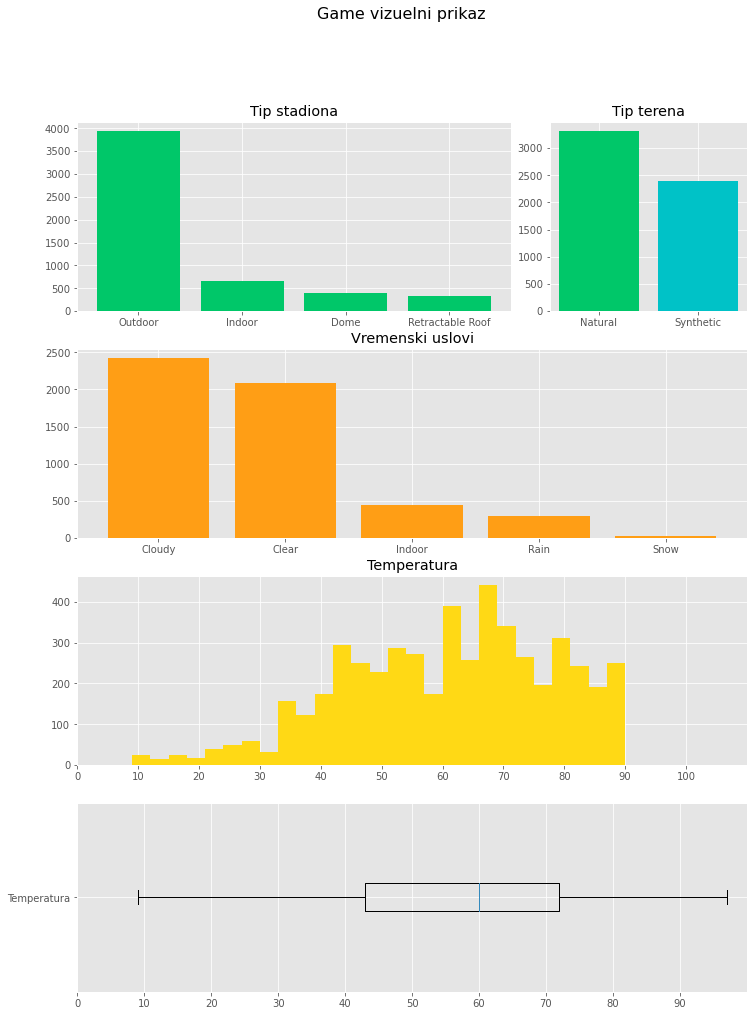

In [8]:
play_data_c = c_play_data(data_play)
game_data_c = play_data_c[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])
vizuelizacija_game(game_data_c, rotation=0, add_labels = False, figsize=(12,16))

Na grafovima vidimo:

* Većina mečeva se igra napolju, zbog toga je vreme važan faktor.
* Većina mečeva se igra na terenima sa prirodnom travom, ali ne treba izostaviti terene sa veštačkom travom jer se veliki broj mečeva igra baš na takvim terenima.
* Temperatura i drugi vremenski uslovi variraju u određenoj meri.

3. Statistika igrača

In [9]:
statistika_igraca = play_data_c[['PlayerKey', 'RosterPosition', 'PlayerGamePlay', 'Position', 'PositionGroup']]

In [10]:
def vizuelizacija_igrača(data_player, figsize=(15,15), add_labels=False):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(3, 4, hspace=0.2, wspace=0.2)
    
    #Kreiranje grafikona
    akcije_axes = fig.add_subplot(grid[0, 0:2])
    max_br_akcija_po_igracu_axes = fig.add_subplot(grid[1, 0:2])
    
    roster_pozicija_axes = fig.add_subplot(grid[0, 2:])
    grupisane_pozicije_axes = fig.add_subplot(grid[1, 2:])
    pozicija_axes = fig.add_subplot(grid[2, 0:])
    
    akcije_axes.hist(data_player.groupby(by=['PlayerKey']).count()['RosterPosition'].values, bins=30, color='#f61e41')
    akcije_axes.set_title('Broj akcija po igraču', fontsize=12)
    
    max_br_akcija_po_igracu_axes.hist(data_player.groupby(by=['PlayerKey']).PlayerGamePlay.max().values, bins=30, color='#f61e41')
    max_br_akcija_po_igracu_axes.set_title('Maksimalan broj akcija po igraču', fontsize=12)
    
    roster_pozicija_axes.bar(data_player.RosterPosition.value_counts().keys().values, data_player.RosterPosition.value_counts().values, color='#aa0055')
    roster_pozicija_axes.set_xticklabels(data_player.RosterPosition.value_counts().keys().values, rotation=15, fontsize=8)
    roster_pozicija_axes.set_title('Pozicija na rosteru', fontsize=12)
    if add_labels:
        add_value_labels(rosterposition_axes, spacing=5)
    
    pozicija_axes.bar(data_player.Position.value_counts().keys().values, data_player.Position.value_counts().values, color='#f7e200')
    pozicija_axes.set_xticklabels(data_player.Position.value_counts().keys().values, rotation=20)
    pozicija_axes.set_title('Pozicija', fontsize=12)
    if add_labels:
        add_value_labels(pozicija_axes, spacing=5)
        
    grupisane_pozicije_axes.bar(data_player.PositionGroup.value_counts().keys().values, data_player.PositionGroup.value_counts().values,color='#aa0055')
    grupisane_pozicije_axes.set_xticklabels(data_player.PositionGroup.value_counts().keys().values, rotation=20)
    grupisane_pozicije_axes.set_title('Grupisane pozicije', fontsize=12)
    if add_labels:
        add_value_labels(grupisane_pozicije_axes, spacing=5)
    
    plt.suptitle('Statistika igrača', fontsize=15)
    plt.show()

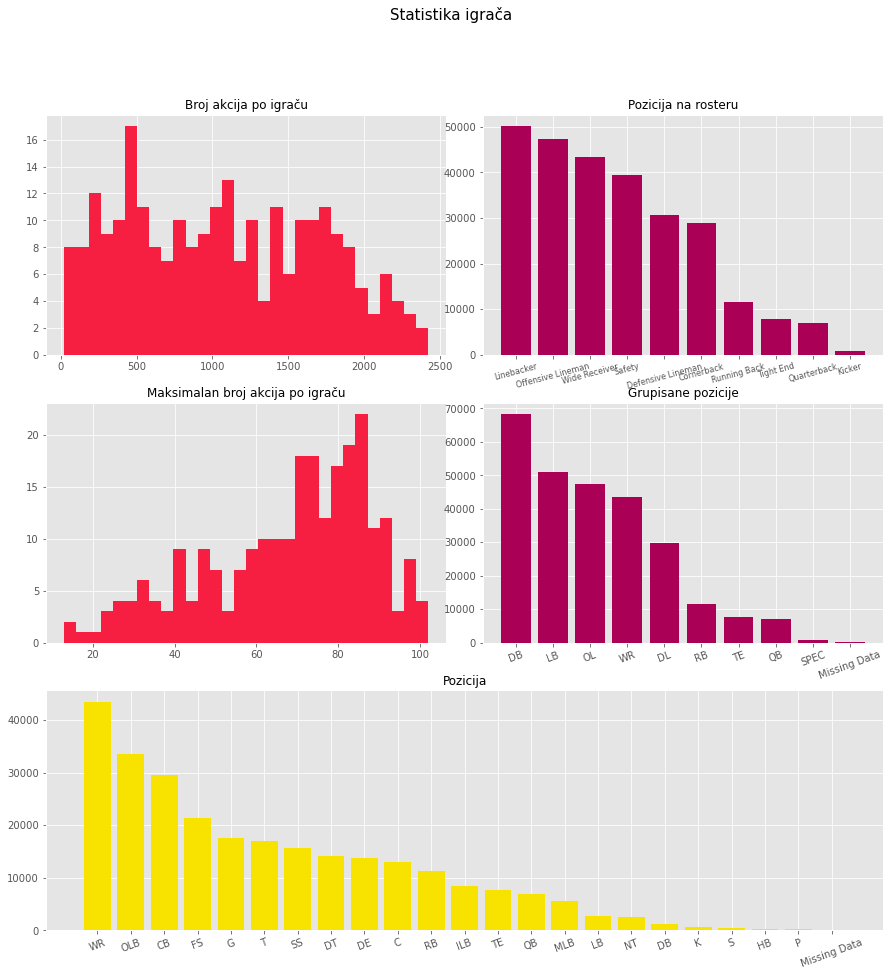

In [11]:
vizuelizacija_igrača(statistika_igraca, add_labels=False)

Diagram gore prikazuje:

* Postoji mnogo različitih pozicija.
* Neki igrači provode više vremena u igri od drugih igrača.

Sve to može dovesti do povreda igrača.

4. Akcije

In [12]:
def vizuelizacija_akcija(play_data_c):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    
    plt.bar(play_data_c.PlayType.value_counts().keys().values, play_data_c.PlayType.value_counts().values,color='#f76700')
    
    plt.xticks(range(len(play_data_c.PlayType.value_counts().keys().values)), 
               play_data_c.PlayType.value_counts().keys().values, rotation=20,)
    #add_value_labels(ax, spacing=5)
    plt.title('Tipovi odigranih akcija', fontsize=15)
    
    plt.show()

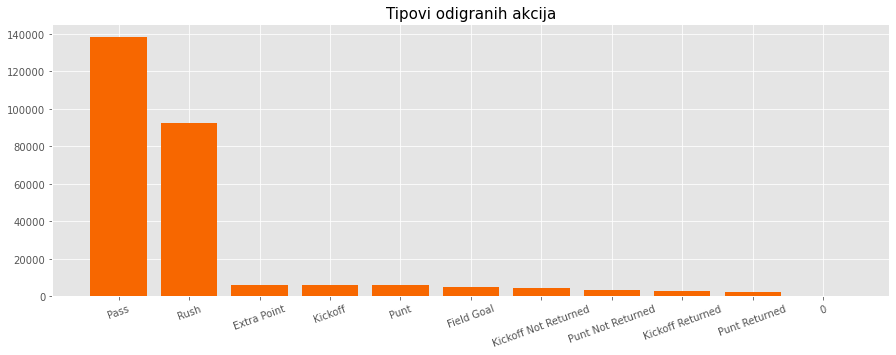

In [13]:
vizuelizacija_akcija(play_data_c)

Na diagramu vidimo da je najviše akcija odigrano pas igrom i trčanjem. Pretpostavljamo da je najviše povreda nastalo iz ovih akcija.

### Povrede

Injury EDA,
Kratak pregled podataka u data_injury setu

In [14]:
print('Ima {} povređenih u setu podataka'.format(len(data_injury)))

Ima 105 povređenih u setu podataka


In [15]:
print('Ima {} različitih povređenih igrača'.format(len(data_injury.PlayerKey.unique())))

Ima 100 različitih povređenih igrača


5 igrača je bilo povređeno više od jednog puta

In [16]:
print('Ima', data_injury['PlayKey'].isnull().sum(), 'nedostajućih PlayKey vrednosti')

Ima 28 nedostajućih PlayKey vrednosti


In [17]:
def vizuelizacija_povreda(data_injury):
    injury_data_c = data_injury.copy()
    injury_data_c.DM_M1 = injury_data_c.DM_M1 - injury_data_c.DM_M7
    injury_data_c.DM_M7 = injury_data_c.DM_M7 - injury_data_c.DM_M28
    injury_data_c.DM_M28 = injury_data_c.DM_M28 - injury_data_c.DM_M42
    
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    
    axs[0].bar(injury_data_c.BodyPart.value_counts().keys().values, injury_data_c.BodyPart.value_counts().values, color='#fa8072')
    axs[0].set_title('Povredjeni delovi tela')
    #add_value_labels(axs[0], spacing=5)
    
    axs[1].bar(injury_data_c.Surface.value_counts().keys().values, injury_data_c.Surface.value_counts().values, color='#00c452')
    axs[1].set_title('Tip Terena')
    #add_value_labels(axs[1], spacing=5)
    
    M1 = injury_data_c.DM_M1.sum()
    M7 = injury_data_c.DM_M7.sum()
    M28 = injury_data_c.DM_M28.sum()
    M42 = injury_data_c.DM_M42.sum()
    
    axs[2].bar(['1-7', '7-28', '28-42', '>=42'], [M1, M7, M28, M42], color='#2f4f4f')
    axs[2].set_title('Nedostajući dani')
    #add_value_labels(axs[2], spacing=5)
    
    plt.suptitle('Povrede', fontsize=16)
    plt.show()

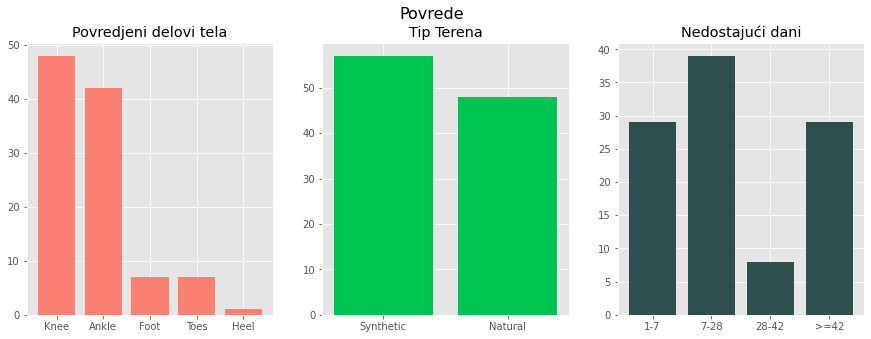

In [18]:
vizuelizacija_povreda(data_injury)

## Analiza povreda

Spajamo tabele data_injury i game_data. Istražićemo zavisnost između ova dve tabele. Hoćemo da vidimo da li postoji korelacija između karakteritika ove dve tabele.

In [19]:
# spajanje join tehnikom dve tabele (data_injury i game_data_c(već ranije sređen data set))
injury_game_data = data_injury.set_index('GameID').join(game_data_c.set_index('GameID'), how = 'outer')

# popunjavanje nedostajućih vrednosti
injury_game_data['DM_M1'] = injury_game_data['DM_M1'].fillna(0).astype(int)
injury_game_data['DM_M7'] = injury_game_data['DM_M7'].fillna(0).astype(int)
injury_game_data['DM_M28'] = injury_game_data['DM_M28'].fillna(0).astype(int)
injury_game_data['DM_M42'] = injury_game_data['DM_M42'].fillna(0).astype(int)

injury_game_data.DM_M1 = injury_game_data.DM_M1 - injury_game_data.DM_M7
injury_game_data.DM_M7 = injury_game_data.DM_M7 - injury_game_data.DM_M28
injury_game_data.DM_M28 = injury_game_data.DM_M28 - injury_game_data.DM_M42

# kreiranje kolone koja označava povredu
injury_game_data['Injury'] = injury_game_data['DM_M1'] + injury_game_data['DM_M7'] + injury_game_data['DM_M28'] + injury_game_data['DM_M42']

# izbacivanje duplikata i kolone Surface, PlayerKey, PlayKey
injury_game_data = injury_game_data.drop(columns=['Surface'])

injury_game_data = injury_game_data.drop(columns=['PlayerKey', 'PlayKey'])

# kreiranje dummy varijabli
injury_game_data_dummy = pd.get_dummies(injury_game_data, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

Korelacija

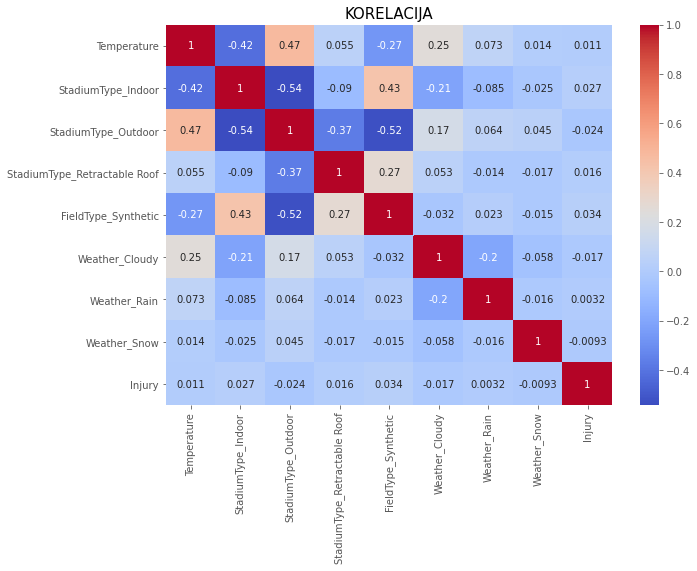

In [20]:
korelacija = injury_game_data_dummy[['Temperature', 'StadiumType_Indoor', 'StadiumType_Outdoor', 
                                     'StadiumType_Retractable Roof', 'FieldType_Synthetic', 'Weather_Cloudy', 
                                     'Weather_Rain', 'Weather_Snow', 'Injury']].corr()

fig = plt.figure(figsize=(10,7))
sns.heatmap(korelacija, annot=True, cmap='coolwarm')
plt.title('KORELACIJA', fontsize=15)
plt.show()

Kao što vidimo da ne postoji značajna korelacija između kolone Injury i svih ostalih varijabli.

#### Temperatura

In [21]:
# uzimamo vrednost temeperature za utakmice
# uzimamo u obzir samo terene koji su na otvoreneom (StadiumType = Outdoor)

bez_povreda_temp = injury_game_data[(injury_game_data.StadiumType == 'Outdoor') & (injury_game_data.Temperature >= 0) & (injury_game_data.Injury == 0)].Temperature.values

povrede_temp = injury_game_data[(injury_game_data.StadiumType == 'Outdoor') & (injury_game_data.Temperature >= 0) & (injury_game_data.Injury == 1)].Temperature.values

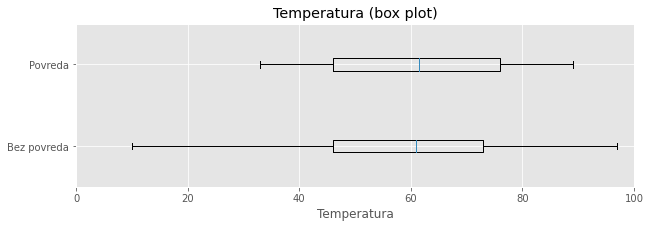

In [22]:
figure = plt.figure(figsize=(10,3))
plt.boxplot([bez_povreda_temp, povrede_temp], vert = False)
plt.title('Temperatura (box plot)')
plt.yticks([1,2], ['Bez povreda', 'Povreda'])
plt.xlim(0,100)
plt.xlabel('Temperatura')
plt.show()

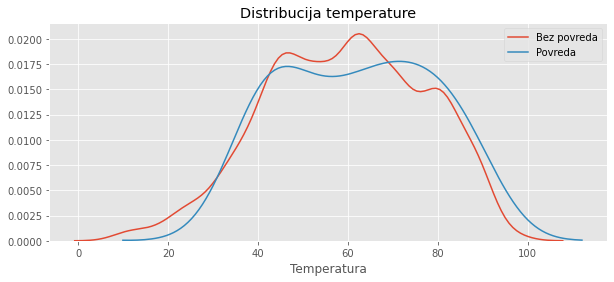

In [23]:
fig, axs = plt.subplots(1,1, figsize=(10,4))
sns.kdeplot(bez_povreda_temp, label = 'Bez povreda')
sns.kdeplot(povrede_temp, label = 'Povreda')
plt.title('Distribucija temperature')
plt.xlabel('Temperatura')
plt.show()

 Radimo Kolomogorov-Smirnov test da b proverili da li uzorci potiču iz iste raspodele

In [24]:
D, p_vrednost = ss.ks_2samp(bez_povreda_temp, povrede_temp)
D, p_vrednost

(0.09720742964110508, 0.5577315244251363)

P vrednost je visoka. Ne možemo da kažemo da vrednosti (Temperature) potiču iz različitih raspodela

Testiranje hipoteza!

Veća je verovatnoća da će se igrač povrediti ako se igra na terenu sa veštačkom travom, kao što je gore na grafikonu prikazano.

Testiraćemo hipotezu da vidimo da li je to statistički značajno:

* H0 - Ne postoji statistički značajna razlika između broja povreda na terenu sa prirodnom i veštačkom travom.
* H1 - Postoji statistički značajna razlika između broja povreda na terenu sa prirodnom i veštačkom travom.

In [25]:
# računanje verovatnoće povreda na veštačkom i prirodnom terenu 
p_povreda = injury_game_data[['FieldType', 'Injury']].groupby('FieldType').mean()['Injury']
p_povreda

FieldType
Natural      0.014497
Synthetic    0.023730
Name: Injury, dtype: float64

In [26]:
prirodni_teren = injury_game_data[['FieldType', 'Injury']].groupby('FieldType').size()[0]
vestacki_teren = injury_game_data[['FieldType', 'Injury']].groupby('FieldType').size()[1]

p_vrednost = injury_game_data[['FieldType', 'Injury']][injury_game_data.FieldType == 'Natural'].mean()[0]

In [27]:
# računanje standardne greške
std_p = np.sqrt(p_vrednost * (1-p_vrednost) * (1/prirodni_teren + 1/vestacki_teren))

#  računanje z-skora i p-vrednosti
z = (p_povreda[1] - p_povreda[0]) / std_p

print('Vrednost z-skora je: {}'.format(z))
print('Vrednost p-vrednosti je: {}'.format(1-ss.norm.cdf(z)))

Vrednost z-skora je: 2.882114721816435
Vrednost p-vrednosti je: 0.001975079424302306


Odbacujemo nultu hipotezu u korist alternativne hipoteze ako je p-vrednost manja od 0.05 (P<0.05). U ovom slučaju sa sigurnošću od 95% kažemo da je verovatnoća od povreda na veštačkom terenu veća od verovatnoće povrede na terenu sa prirodnom travom. Zaključujemo da je veća verovatnoća da se igrači povrede ako se utakmica igra na terenu sa veštačkom travom.

In [29]:
# spajanje dve tabele join metodom (data_injury i play_data_c)
injury_play_data = data_injury.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_data_c.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# popunjvanje nedostajućih vrednosti
injury_play_data['DM_M1'] = injury_play_data['DM_M1'].fillna(0).astype(int)
injury_play_data['DM_M7'] = injury_play_data['DM_M7'].fillna(0).astype(int)
injury_play_data['DM_M28'] = injury_play_data['DM_M28'].fillna(0).astype(int)
injury_play_data['DM_M42'] = injury_play_data['DM_M42'].fillna(0).astype(int)

# kreiranje kolone koja označava povredu
injury_play_data.DM_M1 = injury_play_data.DM_M1 - injury_play_data.DM_M7
injury_play_data.DM_M7 = injury_play_data.DM_M7 - injury_play_data.DM_M28
injury_play_data.DM_M28 = injury_play_data.DM_M28 - injury_play_data.DM_M42

injury_play_data['Injury'] = injury_play_data['DM_M1'] + injury_play_data['DM_M7'] + injury_play_data['DM_M28']+ injury_play_data['DM_M42']

# izbacivanje duplikata iz kolone Surface
injury_play_data = injury_play_data.drop(columns=['Surface'])

# kreiranje dummy varijable
injury_play_data_dummy = pd.get_dummies(injury_play_data, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

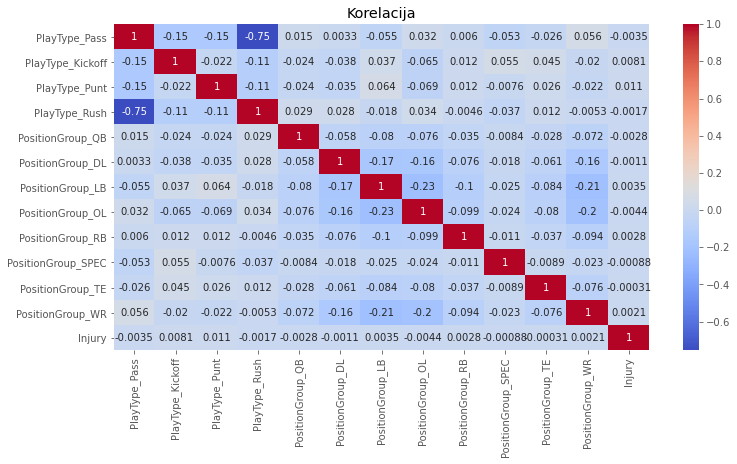

In [30]:
korelacija = injury_play_data_dummy[['PlayType_Pass', 'PlayType_Kickoff', 'PlayType_Punt', 'PlayType_Rush',
                                  'PositionGroup_QB', 'PositionGroup_DL', 'PositionGroup_LB', 'PositionGroup_OL',
                                  'PositionGroup_RB', 'PositionGroup_SPEC', 'PositionGroup_TE', 'PositionGroup_WR',
                                  'Injury']].corr()

figure = plt.figure(figsize=(12,6))
sns.heatmap(korelacija, annot=True, cmap='coolwarm')
plt.title('Korelacija')
plt.show()

Takođe nema značajnih korelacija između kolone poveda (injury) i ostalih kolona (karakteritika)

Sledeća stvar je da ispitamo da li je u zavisnosti od pozicije igrača, broja odigranih utakmica i brzina igrača u korelaciji sa kolonom povrede (injury)

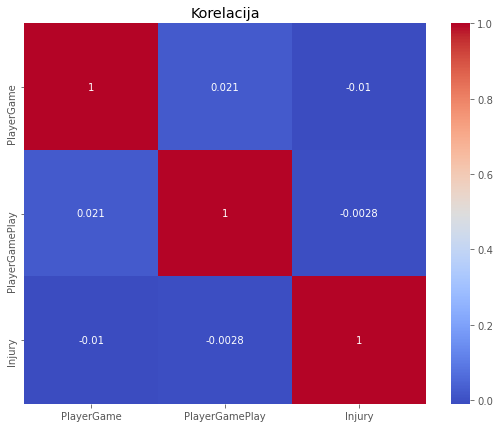

In [31]:
injury_play = injury_play_data[['PlayerGame', 'PlayerGamePlay', 'Injury']]
korelacija = injury_play.corr()

figure = plt.figure(figsize=(9,7))
sns.heatmap(korelacija, annot=True, cmap='coolwarm')
plt.title('Korelacija')
plt.show()

Vidimo da nema značajne korelacije između broja odigranih utakmica i akcija po utakmici sa kolonom povreda (injury).

## Prirodni teren VS Veštački teren

Testiranjem hipoteze dokazano je da postoji veća verovatnoća da će se igrač povrediti na terenu sa veštačkom travom. U nastavku ćemo dublje analizirati faktore koji dovode do povreda na ovim terenima.

1. Vremenski uslovi tokom igranja utakmice na veštačkom i prirodnom terenu

In [32]:
#grupišemo kolone FieldType i StadiumType
group_data = injury_game_data.groupby(by=['FieldType', 'StadiumType']).count().reset_index()

# broj mečeva koji su odigrani na terenu sa prirodnom travom za svaki tip stadiona
prirodni_teren_g = group_data[group_data.FieldType == 'Natural'][['StadiumType','Injury']]
prirodni_teren_g = prirodni_teren_g.append({'StadiumType':'Indoor',  'Injury' : 0}, ignore_index = True).sort_values(by=['StadiumType'])

# broj mečeva koji su odigrani na terenu sa veštačkom travom za svaki tip stadiona
vestacki_teren_g = group_data[group_data.FieldType == 'Synthetic'][['StadiumType','Injury']].sort_values(by=['StadiumType'])

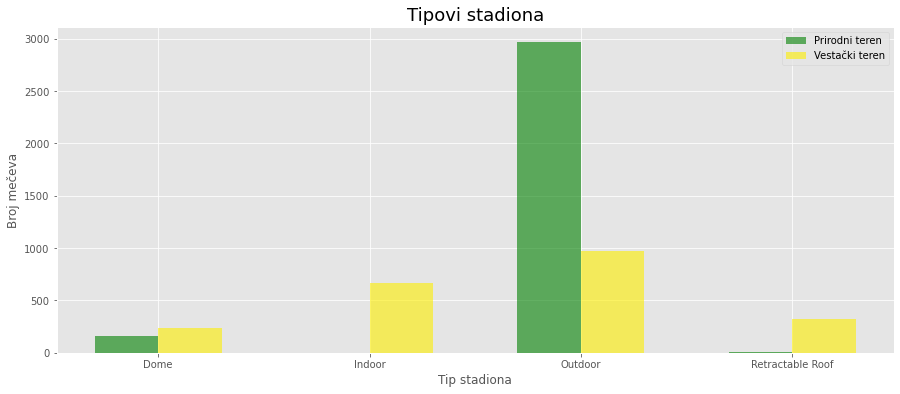

In [33]:
# Prikazivanje prirodnog i veštačkog terena po tipu stadiona
n_group = len(prirodni_teren_g)
fig, ax = plt.subplots(figsize=(15,6))
index = np.arange(n_group)
sirina_bara = 0.30


r1 = plt.bar(index, prirodni_teren_g.Injury.values, sirina_bara,
alpha=0.6,
color='#008000',
label='Prirodni teren')

r2 = plt.bar(index + sirina_bara, vestacki_teren_g.Injury.values, sirina_bara,
alpha=0.6,
color='#FDEE00',
label='Vestački teren')

plt.xticks(index + sirina_bara/2, prirodni_teren_g.StadiumType.values)
plt.xlabel('Tip stadiona')
plt.ylabel('Broj mečeva')
plt.legend()
plt.title('Tipovi stadiona', fontsize=18)
plt.show()

Po onome što vidimo na grafikonu zaključujemo da se većina utakmica igra na otvorenom. Možemo videti da se dosta utakmica odigra na otvorenom ali na terenima sa veštačkom travom. Hajde da vidimo da li loši vremenski uslovi mogu da povećaju rizik od povreda?

In [34]:
vrem_uslovi_prirodni_tr = injury_game_data[(injury_game_data['StadiumType'] == 'Outdoor') & (injury_game_data['FieldType'] == 'Natural')]\
.groupby(by=['Weather']).sum().reset_index().sort_values(by=['Weather'])

vrem_uslovi_vestacki_tr = injury_game_data[(injury_game_data['StadiumType'] == 'Outdoor') & (injury_game_data['FieldType'] == 'Synthetic')]\
.groupby(by=['Weather']).sum().reset_index().sort_values(by=['Weather'])

Text(0.5, 1.0, 'Broj povreda tokom različitih vremenskih uslova')

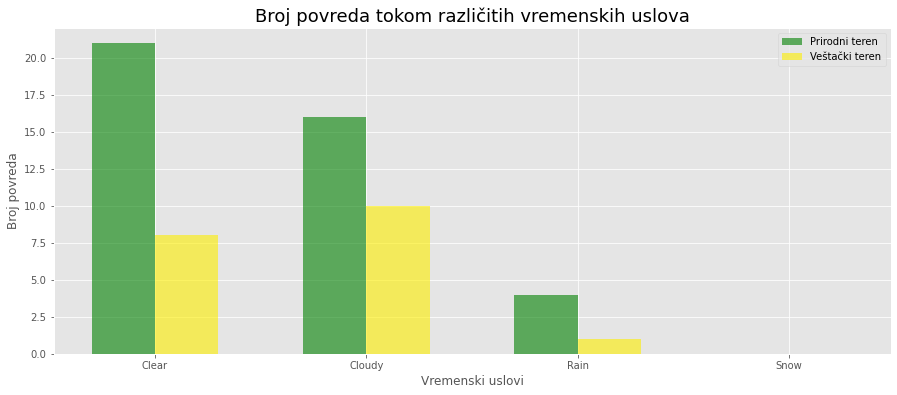

In [35]:
# Povrede tokom različitih vremenskih uslova
n_group = len(vrem_uslovi_vestacki_tr)
fig, ax = plt.subplots(figsize=(15,6))
index = np.arange(n_group)
sirina_bara = 0.30

r1 = plt.bar(index, vrem_uslovi_prirodni_tr.Injury.values, sirina_bara,
alpha=0.6,
color='#008000',
label='Prirodni teren')

r2 = plt.bar(index + sirina_bara, vrem_uslovi_vestacki_tr.Injury.values, sirina_bara,
alpha=0.6,
color='#FDEE00',
label='Veštački teren')

plt.xticks(index + sirina_bara/2, vrem_uslovi_vestacki_tr.Weather.values)
plt.xlabel('Vremenski uslovi')
plt.ylabel('Broj povreda')
plt.legend()
#add_value_labels(ax)
plt.title('Broj povreda tokom različitih vremenskih uslova', fontsize=18)

In [36]:
vrem_uslovi_prirodni_tr = injury_game_data[(injury_game_data['StadiumType'] == 'Outdoor') & (injury_game_data['FieldType'] == 'Natural')]\
.groupby(by=['Weather']).mean().reset_index().sort_values(by=['Weather'])

vrem_uslovi_vestacki_tr = injury_game_data[(injury_game_data['StadiumType'] == 'Outdoor') & (injury_game_data['FieldType'] == 'Synthetic')]\
.groupby(by=['Weather']).mean().reset_index().sort_values(by=['Weather'])

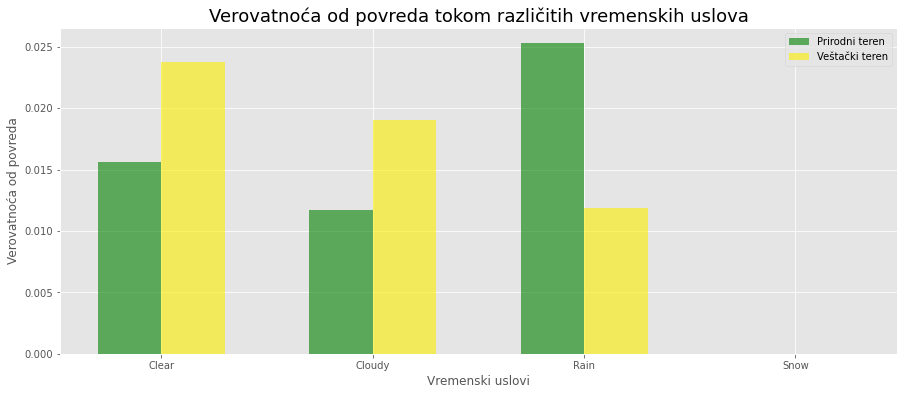

In [37]:
# Verovatnoća od povreda tokom različitih vremenskih uslova
n_group = len(vrem_uslovi_vestacki_tr)
fig, ax = plt.subplots(figsize=(15,6))
index = np.arange(n_group)
sirina_bara = 0.30

r1 = plt.bar(index, vrem_uslovi_prirodni_tr.Injury.values, sirina_bara,
alpha=0.6,
color='#008000',
label='Prirodni teren')

r2 = plt.bar(index + sirina_bara, vrem_uslovi_vestacki_tr.Injury.values, sirina_bara,
alpha=0.6,
color='#FDEE00',
label='Veštački teren')

plt.xticks(index + sirina_bara/2, vrem_uslovi_vestacki_tr.Weather.values)
plt.xlabel('Vremenski uslovi')
plt.ylabel('Verovatnoća od povreda')
plt.legend()
plt.title('Verovatnoća od povreda tokom različitih vremenskih uslova', fontsize=18)
plt.show()

Na grafikonu vidimo da:

* Postoji velika verovatnoća od povreda tokom kišnih vremenskih uslova na terenima sa prirodnom travom.
* Postoji velika verovatnoća od povreda tokom sunčanih vremenskih uslova na terenim sa veštačkom travom.

Na osnovu ovih inforamcija postavljamo sledeća pitanja:

1. Da li je prirodna trava klizavija od veštačke trave tokom kišnih vremenskih uslova? Da li je veća verovatnoća da se igrači povrede tokom kišnih vremenskih uslova na terenu sa prirodnom travom?

2. Da li je rizičnije igrati na terenima sa veštačkom travom tokom sunčanih vremenskih uslova? Ako se temperatura povećava da li se povećava i verovatnoća od povreda na terenima sa veštačkom travom?

Ispitaćemo hipotezu da je rizik od povreda na prirodnom terenu tokom kišnih vremenskih uslova veći.

* H0: Verovatnoća od povreda na terenima sa prirodnom travom tokom kišnih vremenskih uslova je manja ili jednaka verovatnoći kada su ti uslovi nisu ispunjeni.
* H1: Verovatnoća od povreda na terenima sa prirodnom travom tokom kišnih vremenskih uslova je veća ili jednaka verovatnoći kada su ti uslovi ispunjeni.

In [38]:
data_hypo = injury_game_data[['StadiumType', 'FieldType', 'Weather', 'Injury']][injury_game_data['StadiumType'] == 'Outdoor']

ostali = len(data_hypo[(data_hypo.FieldType != 'Natural') & (data_hypo.Weather != 'Rain')])

prirodni_teren_kisa = len(data_hypo[(data_hypo.FieldType == 'Natural') & (data_hypo.Weather == 'Rain')])

p_vr = len(data_hypo[(data_hypo.FieldType != 'Natural') & (data_hypo.Weather != 'Rain')]) / len(data_hypo)

p_povreda1 = data_hypo[(data_hypo.FieldType == 'Natural') & (data_hypo.Weather == 'Rain')].Injury.mean()
p_povreda0 = data_hypo[(data_hypo.FieldType != 'Natural') & (data_hypo.Weather != 'Rain')].Injury.mean()

# standardna devijacija
std_p = np.sqrt(p_vr * (1-p_vr) * (1/ostali + 1/n_prirodni_teren_kisa))

#  z-skor i p-vrednosti
z = (p_povreda1 - p_povreda0) / std_p

print('Vrednosti z-skora je: {}'.format(z))
print('P-vrednost iznosi: {}'.format(1-ss.norm.cdf(z)))

Vrednosti z-skora je: 0.10799355288655726
P-vrednost iznosi: 0.4570004031759113


P vrednost je velika (0.45), ne odbacujemo nultu hipotezu u korist alternativne hioteze. Ne postoji statistička značajnost u tome da je prirodna trava rizičnija za igrače kada su kišni uslovi.

Testiramo sada našu drugu hipotezu:

* H0: Sa povećanjem temperature tokom sunčanih vremenskih uslova na terenima sa veštačkom travom povećava se i verovatnoća od povreda
* H1: Sa povećanjem temperature tokom sunčanih vremenskih uslova na terenima sa veštačkom travom ne povećava se i verovatnoća od povreda

In [39]:
# distribucija temperature i povreda na veštačkim terenima
temp = injury_game_data[(injury_game_data.StadiumType == 'Outdoor') & (injury_game_data.FieldType == 'Synthetic')& (injury_game_data.Injury == 1)]\
.Temperature.values

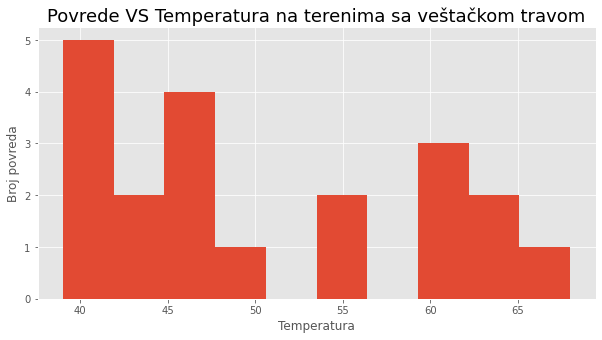

In [40]:
# Povrede VS Temperatura na terenima sa veštačkom travom
plt.figure(figsize=(10,5))
plt.title('Povrede VS Temperatura na terenima sa veštačkom travom', fontsize=18)
plt.xlabel('Temperatura')
plt.ylabel('Broj povreda')
plt.hist(temp)
plt.show()

Moje mišljenje je da veće temperature ne mogu prouzrokovati veći broj povreda što se takođe može zaključiti i sa grafikona. Čak se vidi da niže temperature više utiču na broj povreda. Testiranjem hipoteze ćemo probati da potvrdimo da je veća verovatnoća da se igrači povrede ako je temperatura veća i utakmica se igra na veštačkom terenu.

In [41]:
ostali = len(data_hypo[(data_hypo.FieldType != 'Synthetic') & (data_hypo.Weather != 'Clear')])
vestacki = len(data_hypo[(data_hypo.FieldType == 'Synthetic') & (data_hypo.Weather == 'Clear')])

p_vr = len(data_hypo[(data_hypo.FieldType != 'Synthetic') & (data_hypo.Weather != 'Clear')]) / len(data_hypo)

p_povreda1 = data_hypo[(data_hypo.FieldType == 'Synthetic') & (data_hypo.Weather == 'Clear')].Injury.mean()
p_povreda0 = data_hypo[(data_hypo.FieldType != 'Synthetic') & (data_hypo.Weather != 'Clear')].Injury.mean()

# standardna devijacija
std_p = np.sqrt(p_vr * (1-p_vr) * (1/ostali + 1/vestacki))

#  z-skor i p-vrednost
z = (p_povreda1 - p_povreda0) / std_p

print('Vrednost z-skora je: {}'.format(z))
print('P-value iznosi: {}'.format(1-ss.norm.cdf(z)))

Vrednost z-skora je: 0.3269714097114601
P-value iznosi: 0.37184475473771617


P vrednos je velika. Nemam dovoljno dokaza da odbijemo nultu hipotezu.

Zaključujemo da vremenski uslovi ne dovode do većeg rizika od povreda.

2. Prirodni i veštački teren i pozicija igrača

Pogledaćemo verovatnoće od povreda na veštačkom terenu za različite pozicije:

In [42]:
# verovatnoća od povreda za različite pozicije

# prirodni teren
pozicije_prirodni_teren = injury_play_data[(injury_play_data['FieldType'] == 'Natural')]\
.groupby(by=['Position']).mean().reset_index().sort_values(by=['Position'])

# veštčki teren
pozicije_vestacki_teren = injury_play_data[(injury_play_data['FieldType'] == 'Synthetic')]\
.groupby(by=['Position']).mean().reset_index().sort_values(by=['Position'])

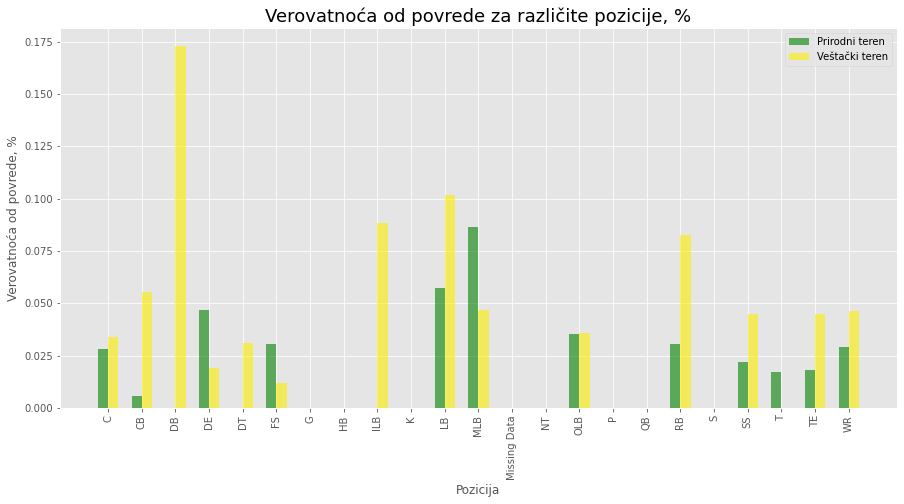

In [43]:
n_group = len(pozicije_prirodni_teren)
fig, ax = plt.subplots(figsize=(15,7))
index = np.arange(n_group)
sirina_bara = 0.30

r1 = plt.bar(index, pozicije_prirodni_teren.Injury.values*100, sirina_bara,
alpha=0.6,
color='#008000',
label='Prirodni teren')

r2 = plt.bar(index + sirina_bara, pozicije_vestacki_teren.Injury.values*100, sirina_bara,
alpha=0.6,
color='#FDEE00',
label='Veštački teren')

plt.xticks(index + sirina_bara/2, pozicije_vestacki_teren.Position.values, rotation=90)
plt.xlabel('Pozicija')
plt.ylabel('Verovatnoća od povrede, %')
plt.legend()
plt.title('Verovatnoća od povrede za različite pozicije, %', fontsize=18)
#add_value_labels(ax, decimals = 1)
plt.show()

Na grafikonu vidimo da igrači na poziciji DB (defensive back) imaju visoku verovatnoću da se povrede na terenu sa veštačkom travom.

Testiraćemo tu hipotezu:

* H0: Postoji velika verovatnoća da će se igrači na poziciji DB povrediti na terenu sa veštačkom travom.
* H1: Ne postoji velika verovatno da će se igrači na poziciji DB povrediti na terenu sa veštačkom travom.

In [44]:
data_hypo = injury_play_data[['FieldType', 'Position', 'Injury']]

ostali = len(data_hypo[(data_hypo.FieldType != 'Synthetic') & (data_hypo.Position != 'DB')])
vestacki_teren_db = len(data_hypo[(data_hypo.FieldType == 'Synthetic') & (data_hypo.Position == 'DB')])

p_vrednost = len(data_hypo[(data_hypo.FieldType != 'Synthetic') & (data_hypo.Position != 'DB')]) / len(data_hypo)

p_povreda1 = data_hypo[(data_hypo.FieldType == 'Synthetic') & (data_hypo.Position == 'DB')].Injury.mean()
p_povreda0 = data_hypo[(data_hypo.FieldType != 'Synthetic') & (data_hypo.Position != 'DB')].Injury.mean()

# standardna devijacija
std_p = np.sqrt(p_vrednost * (1-p_vrednost) * (1/ostali + 1/vestacki_teren_db))

#  z-skor i p-vrednost
z = (p_povreda1 - p_povreda0) / std_p

print('Vrednost z-skora je: {}'.format(z))
print('P vrednost iznosi: {}'.format(1-ss.norm.cdf(z)))

Vrednost z-skora je: 0.07303732805126828
P vrednost iznosi: 0.4708882066646536


Nemamo dovoljno dokaza da odbacimo nultu hipotezu.Da, postoji veća verovatnoća da se igrači na poziciji DB povrede prilikom igranja utakmce na veštačkom terenu.

Zaključak:
    
* Sa sigurnošću možemo da kažemo da postoji veliki rizik od povreda kada se igraju utakmice na terenu sa veštačkom travom.
* Visoke temperature ne mogu prouzrokovati veći broj povreda kada se igra na terenima se veštačkom travom.
* Najveći broj utakmica se igra na otvoreno tj. na stadionima bez krova.
* Vremenski uslovi otežavaju igru pa se prilikom loših vremenski uslova više bira igra trčanjem, ali loši vremenski uslovi ne dovode do povreda kod igrača.

## Najbolji atributi za model (Data Engineerig)

1. Pokušaćemo da izdvojimo najbolje atribute kako bi izgradili što bolji model kako bi predvideli povrede kod igrača.


In [74]:
# resetujemo indexe
data_features = injury_play_data.copy().reset_index()
# izbacujemo neodgovarajuće kolone
#data_features = data_features.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
data_features = data_features.drop(columns=['PlayerKey_left','GameID_left', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# prebacujemo u dummy varijablu
data_features = pd.get_dummies(data_features, dummy_na = False, drop_first = True)
#data_features.columns

Delimo podatke na dva skupa X i y

In [75]:
y = data_features['Injury']
X = data_features.drop(columns=['Injury'])

VarienceTreshold tehnika

Eliminišemo sve atribute sa vrijansom manjom od 0.05

In [76]:
#from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(0.05)
selection.fit(X)

print(selection.get_support())
print('--------------------')
print(selection.get_support().sum())

[ True  True  True  True False False  True False  True  True False False
  True False  True  True  True  True  True  True  True False False False
 False False False False  True False False False  True  True False False
  True  True  True False False False False False False False  True False
 False False False  True  True False  True  True  True False  True False
 False False False  True]
--------------------
29


Izabrali smo 29 atributa metodom eliminisanjem atributa sa malom varijansom. Sada ćemo da vidimo da li dobijamo bolje rezultate sa izabranim atributima.

In [78]:
X_reduced = X.loc[:, selection.get_support()]

model = LogisticRegression(solver='liblinear')

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Svi atributi: {scores.mean()}')

scores = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
print(f'Izabrani atributi: {scores.mean()}')
print('dobili smo manju tačnost izbacivanjem atributa')

Svi atributi: 0.99982397417543
Izabrani atributi: 0.9997116170094726
dobili smo manju tačnost izbacivanjem atributa


Tehnikom Hi kvadrat test i zajednička informacija probaćemo da nađemo najbolej atribute za model.

In [80]:
#from sklearn.feature_selection import chi2
#from sklearn.feature_selection import mutual_info_classif

print(mutual_info_classif(X, y))
print(len(mutual_info_classif(X, y)))

[5.80657335e-04 1.73848502e-03 2.80801583e-03 6.09758445e-04
 1.86647520e-04 1.16989552e-03 8.89308635e-04 0.00000000e+00
 2.41694462e-03 2.00613375e-03 2.55522350e-05 6.86393129e-05
 1.37151585e-03 6.96642837e-05 1.63405599e-03 9.12428282e-04
 3.11808120e-02 2.45021122e-04 1.09767419e-02 1.20611417e-02
 3.90810513e-04 1.68385812e-04 6.36334331e-06 6.01099189e-05
 5.62361599e-06 1.44577667e-05 3.29693405e-05 3.53293742e-05
 1.74246486e-02 4.25497912e-05 2.18702354e-06 0.00000000e+00
 8.09548262e-03 6.39568780e-04 0.00000000e+00 2.39561024e-04
 1.62684915e-04 4.44066982e-04 3.20458277e-04 4.84711211e-06
 1.91173874e-05 0.00000000e+00 2.25958596e-05 5.92642181e-05
 0.00000000e+00 4.16638237e-05 9.98047843e-04 4.27770508e-05
 4.79039424e-05 1.35729048e-04 0.00000000e+00 2.21005252e-04
 2.61202951e-04 1.61543393e-05 1.76348217e-03 8.07946215e-04
 2.39009975e-03 0.00000000e+00 1.99135504e-03 2.55373492e-05
 1.89923596e-04 0.00000000e+00 9.72791685e-06 1.57408112e-03]
64


In [83]:
#from sklearn.feature_selection import SelectKBest

selection = SelectKBest(k=40, score_func=mutual_info_classif)  

selection.fit(X, y)
selection.get_support()

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True,  True, False, False,  True,  True, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
        True])

In [85]:
X_reduced = X.loc[:, selection.get_support()]

model = LogisticRegression(solver='liblinear')

scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f'Svi atributi: {scores.mean()}')

scores = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
print(f'Izabrani atributi: {scores.mean()}')
print('dobili smo veću tačnost izbacivanjem atributa')

Svi atributi: 0.99982397417543
Izabrani atributi: 0.9998314646017296
dobili smo veću tačnost izbacivanjem atributa


Logističkom regresijom ćemo pokušati da nađemo najbolje atribute za model

In [86]:
model = LogisticRegression(solver='liblinear')

model.fit(X, y)

model.coef_

array([[ 3.14631718e-03, -1.45389092e-01,  6.32229145e-04,
        -4.20298212e-03,  5.54050446e+00,  9.19801767e+00,
        -5.30894588e-01, -2.86369270e-01, -2.95940570e-01,
        -4.57178268e-01, -5.95857804e-01, -3.57649023e-01,
        -7.21741342e-01, -3.61936824e-01, -2.69156368e-01,
        -5.18083509e-01, -5.82932398e-01, -2.69245960e-01,
         2.87235933e-01, -2.73575836e-01,  1.07559777e-01,
        -1.60167303e-01, -1.27629478e-01, -9.37594603e-01,
        -8.61256400e-01, -2.90008164e-01, -7.98239217e-01,
        -4.87200689e-01, -9.22245915e-01,  8.22352836e-02,
        -3.06685379e-01,  3.22528944e-01, -6.92469446e-01,
        -7.50602148e-01, -3.12310587e-01,  2.62583463e-01,
        -5.37958280e-01, -2.82203250e-01, -1.05954275e+00,
        -9.18369528e-02, -4.22858375e-01, -1.91617460e-01,
         2.59660035e-01,  3.59498430e-01, -2.46902090e-02,
        -3.03556482e-01, -4.42413243e-01, -9.47518096e-02,
        -5.86473414e-01, -2.33106503e-01, -1.86872889e-0

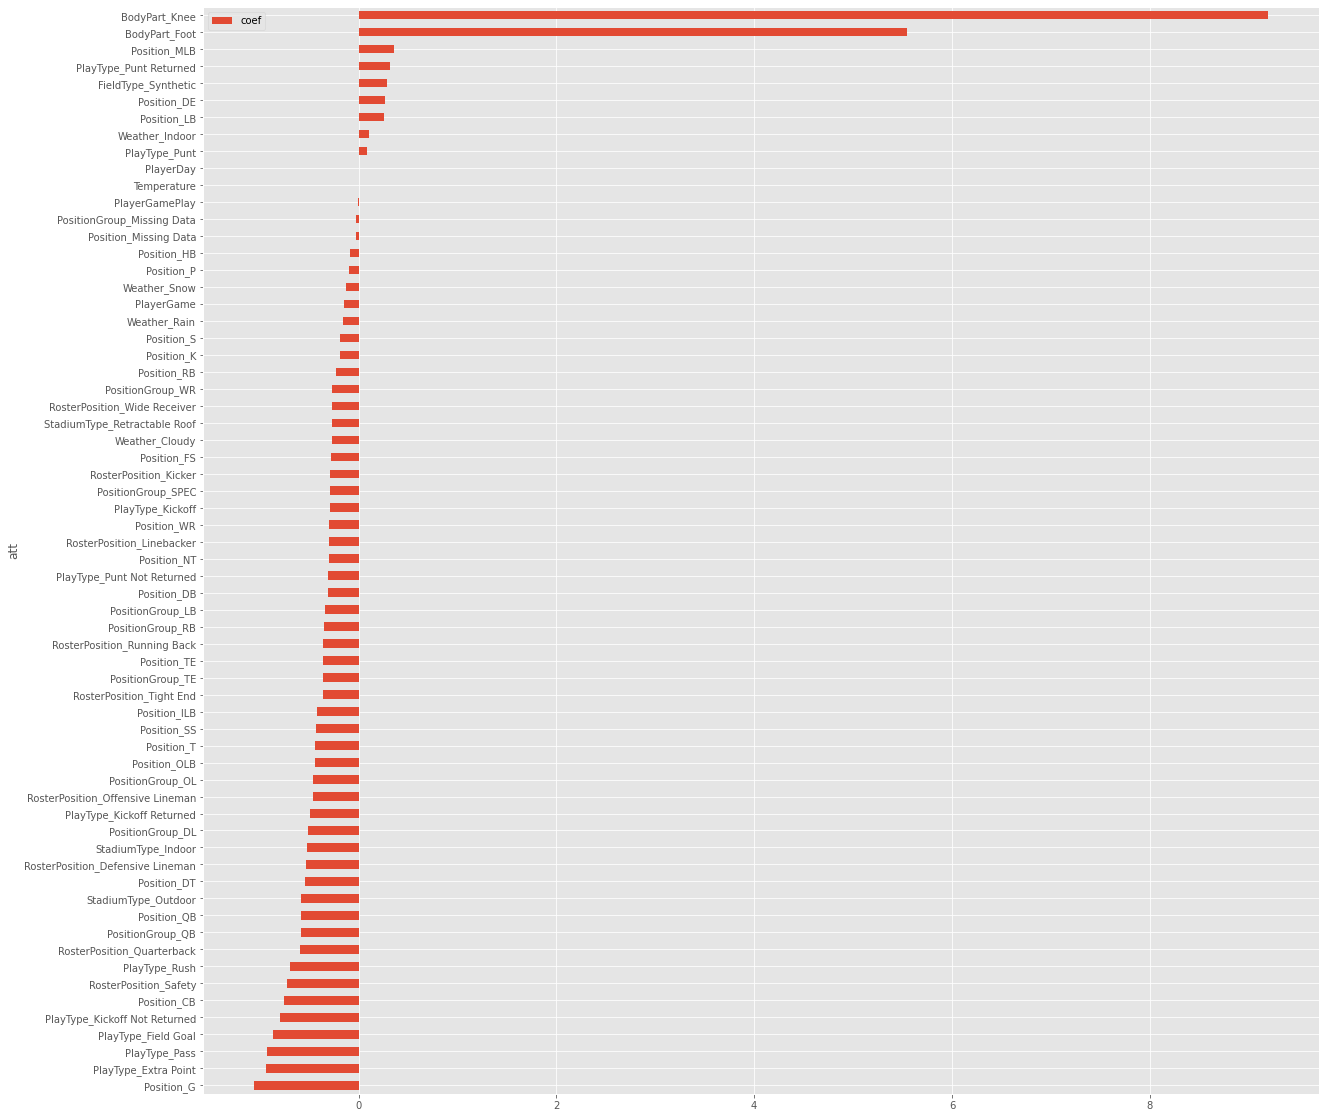

In [87]:
coefs = pd.DataFrame({'att':X.columns, 'coef':model.coef_[0]}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.replace(0,np.nan).dropna().plot.barh(x='att',y='coef',figsize=(20, 20))

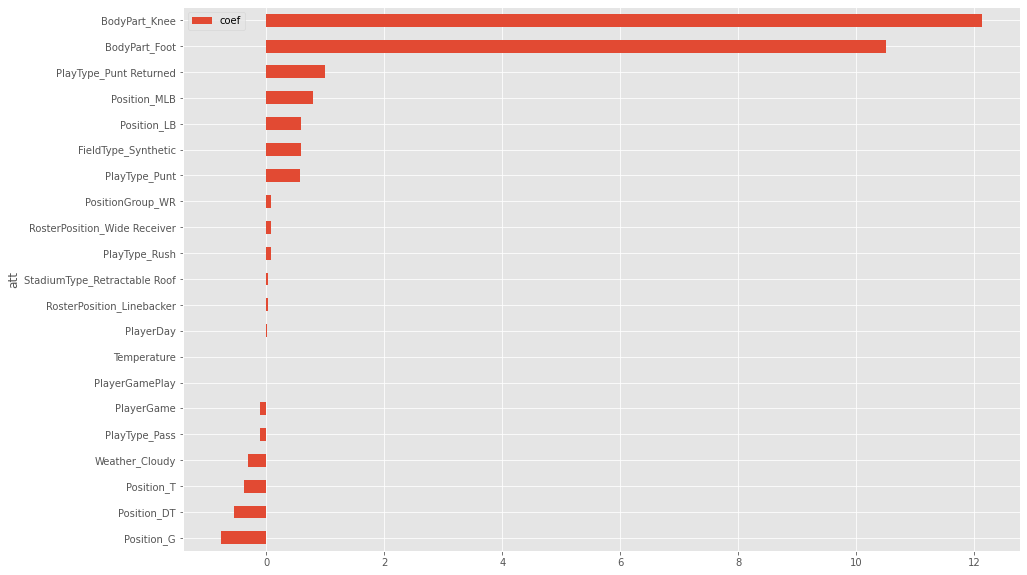

In [88]:
#kada dodamo penal l1 - ako je koef=0 onda taj atribut nije bitan
model = LogisticRegression(penalty='l1', solver='liblinear')

model.fit(X, y)

coefs = pd.DataFrame({'att':X.columns, 'coef':model.coef_[0]}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()
coefs.replace(0,np.nan).dropna().plot.barh(x='att',y='coef',figsize=(15, 10))

In [89]:
from sklearn.feature_selection import SelectFromModel
model = LogisticRegression(penalty='l1', solver='liblinear')
#model.fit
sfm = SelectFromModel(model, threshold=0.01)
sfm.fit(X, y)
print(sum(sfm.get_support()))
X.columns[sfm.get_support()]

17


Index(['PlayerGame', 'BodyPart_Foot', 'BodyPart_Knee',
       'RosterPosition_Linebacker', 'RosterPosition_Wide Receiver',
       'StadiumType_Retractable Roof', 'FieldType_Synthetic', 'Weather_Cloudy',
       'PlayType_Pass', 'PlayType_Punt', 'PlayType_Punt Returned',
       'PlayType_Rush', 'Position_DT', 'Position_G', 'Position_LB',
       'Position_MLB', 'Position_T'],
      dtype='object')

In [91]:
#model = LogisticRegression(penalty='l1', solver='liblinear')
X_reduced = X.loc[:, sfm.get_support()]

scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(f'Svi atributi: {scores.mean()}')

scores = cross_val_score(model, X_reduced, y, cv=10, scoring='accuracy')
print(f'Atrinuti nakon selekcije: {scores.mean()}')
print('dobili smo veću tačnost izbacivanjem atributa')

Svi atributi: 0.9998651714849716
Atrinuti nakon selekcije: 0.9998689166630548
dobili smo veću tačnost izbacivanjem atributa


## Mašinsko učenje

Optimizacija parametara

In [96]:
#Logistička regresija
logistic_params = {'C':np.linspace(start=0.001, stop=5, num=50)}
grid = GridSearchCV(LogisticRegression(), logistic_params, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)

print('Best param: ', grid.best_params_)

Best param:  {'C': 4.795959183673469}


In [101]:
#Stablo odlučivanja (DecisionTree)
params = {'max_leaf_nodes': np.arange(2, 20), 'min_samples_split': np.arange(2,10)}
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)

print('Best param: ', grid.best_params_)

Best param:  {'max_leaf_nodes': 3, 'min_samples_split': 2}


In [102]:
#Random Forest
forest = RandomForestClassifier()

parameters = {'max_features': np.arange(1,10)}
grid = GridSearchCV(forest, parameters, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'max_features': 5}


In [103]:
forest = RandomForestClassifier()

parameters = {'min_samples_leaf': np.arange(1,10)}
grid = GridSearchCV(forest, parameters, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'min_samples_leaf': 2}


In [109]:
#[40,60,80,100,1000]
#[10,20,30,40]
#[11,13,15,17]
forest = RandomForestClassifier()

parameters = {'n_estimators': [11,13,15,17, 18, 20]}
grid = GridSearchCV(forest, parameters, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'n_estimators': 15}


In [105]:
forest = RandomForestClassifier()

parameters = {'max_depth': np.arange(1,10)}
grid = GridSearchCV(forest, parameters, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'max_depth': 5}


In [124]:
#XGBoost
model = xgb.XGBClassifier()
param_grid = [{'max_depht': np.arange(1,5)}]

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

[15:32:31] WARNING: ../src/learner.cc:516: 
Parameters: { max_depht } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:40] WARNING: ../src/learner.cc:516: 
Parameters: { max_depht } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:48] WARNING: ../src/learner.cc:516: 
Parameters: { max_depht } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:32:56] WA

KeyboardInterrupt: 

In [115]:
model = xgb.XGBClassifier()
param_grid = [{'min_child_weight': [1,2,3,4]}]

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'min_child_weight': 1}


In [117]:
model = xgb.XGBClassifier()
param_grid = [{'colsample_bytree': [0, 0.001, 0.005, 0.01, 0.05,0.5,1]}]

grid = GridSearchCV(model, param_grid, cv=5,scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'colsample_bytree': 0.5}


In [118]:
model = xgb.XGBClassifier()
param_grid = [{'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05,1]}]

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'reg_alpha': 0}


In [119]:
model = xgb.XGBClassifier()
param_grid = [{'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05,1]}]

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'reg_lambda': 1}


In [120]:
model = xgb.XGBClassifier()
param_grid = [{'learning_rate':[0, 0.001, 0.005, 0.01, 0.05,1]}]

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'learning_rate': 0.001}


In [136]:
#'n_estimators': [1, 2, 4,10,20,50,80,100]
#[77,78,79,80,81,82,83

model = xgb.XGBClassifier()
param_grid = [{'n_estimators': [100,250,500]}]

grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'n_estimators': 100}


In [138]:
#'n_estimators': [1, 2, 4,10,20,50,80,100]
#'n_estimators': [10,20,30,40,50]
#'n_estimators': [15,18,20,22,25]
#'n_estimators': [20,22,25,27]
#'learning_rate': [0.1,0.2,0.5,1.0]
#'learning_rate': [0.8,1.0,1.2]

dt=DecisionTreeClassifier()
lr=LogisticRegression()

parameters = {'n_estimators': [100,250,500], 'learning_rate': [0.1,0.2,0.5,0.8,1.0,1.2]}
grid = GridSearchCV(AdaBoostClassifier(), parameters, cv=3, scoring='accuracy', error_score='raise')
grid.fit(X_reduced,y)
print('Best param: ', grid.best_params_)

Best param:  {'learning_rate': 0.1, 'n_estimators': 100}


Poređenje performansi algoritma

In [97]:
#Logističa regresija
model = LogisticRegression()

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.98% +/- 0.0%
roc_auc iznosi 85.76% +/- 6.56%


In [98]:
#Logistička regresija nakon optimizovanja parametara
model = LogisticRegression(C=4.795959183673469)

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.99% +/- 0.0%
roc_auc iznosi 86.85% +/- 6.51%


In [99]:
#Stablo odlučivanja 
model = DecisionTreeClassifier()

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.98% +/- 0.0%
roc_auc iznosi 76.62% +/- 5.38%


In [100]:
#Stablo odlučivanja nakom optimizovanja parametara
model = DecisionTreeClassifier(max_leaf_nodes= 3, min_samples_split= 2)

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.99% +/- 0.0%
roc_auc iznosi 77.21% +/- 5.36%


In [110]:
#Random Forest
model = RandomForestClassifier()

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.99% +/- 0.0%
roc_auc iznosi 76.56% +/- 5.43%


In [111]:
#Random Forest nakon optimizovanja parametara
model = RandomForestClassifier(max_depth= 5, max_features=5, min_samples_leaf=2, n_estimators=15)

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.98% +/- 0.0%
roc_auc iznosi 84.11% +/- 8.46%


In [125]:
#XGBoost
model = xgb.XGBClassifier()

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.99% +/- 0.0%
roc_auc iznosi 79.38% +/- 5.71%


In [139]:
#XGBoost nakon optimizovanja parametara
model = xgb.XGBClassifier(max_depth=1,learning_rate=0.001,min_child_weight=1,colsample_bytree=0.5,reg_alpha=0, reg_lambda=1,n_estimators=100 )

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.97% +/- 0.0%
roc_auc iznosi 74.0% +/- 4.73%


In [140]:
#Ada Boost
model = AdaBoostClassifier()

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.99% +/- 0.0%
roc_auc iznosi 84.71% +/- 4.05%


In [141]:
#Ada Boost nakon optimizovanja parametara
model = AdaBoostClassifier(n_estimators= 100, learning_rate = 0.1)

results = cross_val_score(model, X_reduced, y, cv=5, scoring='accuracy')
results1 = cross_val_score(model, X_reduced, y, cv=5, scoring='roc_auc')
print(f'Tačnost iznosi {round(np.mean(results) * 100, 2)}% +/- {round(np.std(results)*100, 2)}%')
print(f'roc_auc iznosi {round(np.mean(results1) * 100, 2)}% +/- {round(np.std(results1)*100, 2)}%')

Tačnost iznosi 99.99% +/- 0.0%
roc_auc iznosi 85.55% +/- 5.82%


In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size = 0.3) 

Ponovno uzorkovanje:

Postoji mali broj igrača sa povredama, tako da podatke ne možemo koristite takve kakvi jesu. Problem je što će naš model predviđati da nema povreda. Zbog toga radimo ponovno uzorkovanje koje će nam pomoći da generišemo više slučajeva iz retke klase (injury) i da naučimo naš model. 

In [145]:
res = RandomOverSampler(random_state=0)
X_resampled, y_resampled = res.fit_resample(X_train, y_train)

In [146]:
model = LogisticRegression(C=4.897979591836735)
model.fit(X_resampled, y_resampled)
predictions = model.predict(X_test)

In [147]:
print(model.predict_proba(X_test)[0])
print(model.predict(X_reduced))

[0.77029872 0.22970128]
[1 1 1 ... 0 0 0]


Text(69.0, 0.5, 'Stvarno')

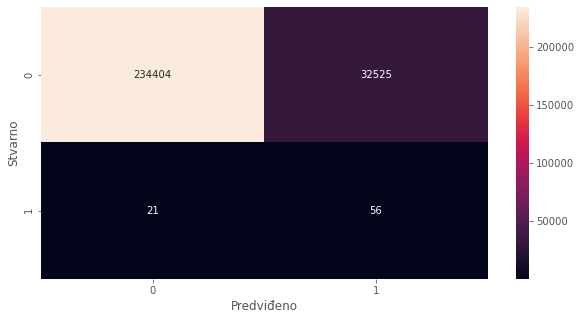

In [148]:
#matrica kofuzije
plt.figure(figsize=(10, 5))
ax = plt.subplot()
sns.heatmap(confusion_matrix(y_true=y, y_pred=model.predict(X_reduced)), ax=ax, annot=True, fmt='g')

ax.set_xlabel('Predviđeno')
ax.set_ylabel('Stvarno')

In [149]:
#Koliko smo dobri
accuracy_score(y_test ,predictions)
f'Naš model ima {round(accuracy_score(y_test, predictions) * 100, 2)}% tačnih predviđanja'

'Naš model ima 87.75% tačnih predviđanja'

In [150]:
#Mikro mere predstavlja uprosečavanje po podacima. 
#from sklearn.metrics import precision_score, recall_score, f1_score

y_hat = model.predict(X_reduced)

prec = precision_score(y, y_hat, average='micro')
rec = recall_score(y, y_hat, average='micro')
f1 = f1_score(y, y_hat, average='micro')

f'Sa drugačijim merama, naš model ima {np.round(prec * 100, 2)}% preciznosti, {np.round(rec * 100, 2)}% odziva i {np.round(f1 * 100, 2)}% F mere'

'Sa drugačijim merama, naš model ima 87.81% preciznosti, 87.81% odziva i 87.81% F mere'

In [151]:
#Makro mere se smatraju pogodnijem za nebalansirane skupove podataka jer daju podjednaku težinu svim klasama.
#Makro mere rade uprosečavanje binarnih vrednosti metrika po klasama.

prec = precision_score(y_test, predictions, average='macro')
rec = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

f'Sa drugačijim merama, naš model ima {np.round(prec * 100, 2)}% preciznosti, {np.round(rec * 100, 2)}% odziva i {np.round(f1 * 100, 2)}% F mere'

'Sa drugačijim merama, naš model ima 50.04% preciznosti, 72.0% odziva i 46.83% F mere'

In [152]:
#Pored mikro i makro mera može se raditi i otežavanje klasa prema broju instanci.

y_hat = model.predict(X_reduced)

prec = precision_score(y, y_hat, average='weighted')
rec = recall_score(y, y_hat, average='weighted')
f1 = f1_score(y, y_hat, average='weighted')

f'Sa drugačijim merama, naš model ima {np.round(prec * 100, 2)}% preciznosti, {np.round(rec * 100, 2)}% odziva i {np.round(f1 * 100, 2)}% F mere'

'Sa drugačijim merama, naš model ima 99.96% preciznosti, 87.81% odziva i 93.48% F mere'

In [153]:
#Ukoliko posmatramo svaki slučaj nezavisno (mikro mere) onda dobijemo koliko nam je model u opštem slučaju dobar. 
#Odnosno, koliko će u celoj populaciji dobro raditi.
#Međutim, neki slučajevi su nam bitniji (i to obično one klase koja se najređe javlja). 
#Zbog te retkosti javljanja, verovatnije je da nju nećemo dobro predviđati. 
#Zbog toga je ponekad prikladno koristiti makro mere.

models = {'XGB': xgb.XGBClassifier(max_depth=1,learning_rate=0.001,min_child_weight=1,colsample_bytree=0.5,reg_alpha=0, reg_lambda=1,n_estimators=100), 
          'Decision Tree': DecisionTreeClassifier(max_leaf_nodes= 3, min_samples_split= 2), 
          'Random Forest': RandomForestClassifier(max_depth= 5, max_features=5, min_samples_leaf=2, n_estimators=15), 
          'Ada Boost': AdaBoostClassifier(n_estimators= 100, learning_rate = 0.1),
          'Log reg': LogisticRegression(C=4.795959183673469)}

result_dict = {}
for name, model in models.items():

    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    result_dict.update(
    { name:
         {'Accuracy': accuracy_score(y_test, y_hat),
          'Precision (micro)': precision_score(y_test, y_hat, average='micro'),      
          'Recall (micro)': recall_score(y_test, y_hat, average='micro'),
          'F1 (micro)': f1_score(y_test, y_hat, average='micro'),
          'Precision (macro)': precision_score(y_test, y_hat, average='macro'),
          'Recall (macro)': recall_score(y_test, y_hat, average='macro'),
          'F1 (macro)': f1_score(y_test, y_hat, average='macro')
        }
    })

In [154]:
pd.DataFrame(result_dict)

,XGB,Decision Tree,Random Forest,Ada Boost,Log reg
Accuracy,0.99980,0.999875,0.999850,0.999850,0.999850
Precision (micro),0.99980,0.999875,0.999850,0.999850,0.999850
Recall (micro),0.99980,0.999875,0.999850,0.999850,0.999850
F1 (micro),0.99980,0.999875,0.999850,0.999850,0.999850
Precision (macro),0.49990,0.999938,0.999925,0.999925,0.999925
Recall (macro),0.50000,0.687500,0.625000,0.625000,0.625000
F1 (macro),0.49995,0.772696,0.699963,0.699963,0.699963


## Evaulacija rešenja

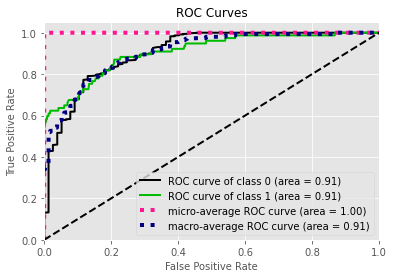

In [156]:
#import scikitplot as skplt

model =LogisticRegression(C=4.795959183673469).fit(X_reduced, y)

skplt.metrics.plot_roc(y, model.predict_proba(X_reduced))

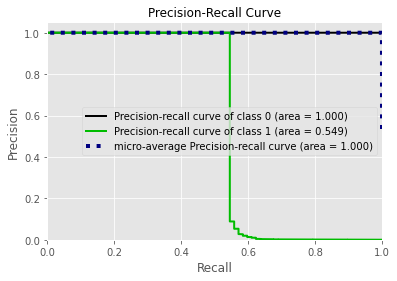

In [157]:
skplt.metrics.plot_precision_recall(y, model.predict_proba(X_reduced))